# Experimental Design
***
## Underlayer Choice

Import the necessary packages and code for this application.

In [1]:
import numpy as np
import sys

# Add to system path to access experimental design code.
sys.path.append('../experimental-design')

from refnx.reflect import SLD, Slab
from refnx.analysis import Parameter

from structures import BaseBilayer
from design import underlayer_choice

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Define the structure that we want to find the optimal underlayer for. The code below defines a model describing a symmetric bilayer. It inherits from the BaseBilayer class which contains the methods for information calculation.

In [2]:
class SymmetricBilayer(BaseBilayer):
    def __init__(self):
        self.name = 'symmetric_bilayer'

        self.si_sld      = 2.073
        self.sio2_sld    = 3.41
        self.dmpc_hg_vol = 320.9
        self.dmpc_tg_vol = 783.3
        self.dmpc_hg_sl  = 6.41e-4
        self.dmpc_tg_sl  = -3.08e-4
        self.water_vol   = 30.4

        # Calculate the SLD of the tailgroup.
        self.tg_sld = (self.dmpc_tg_sl / self.dmpc_tg_vol) * 1e6

        # Define the parameters of the model.
        self.si_rough      = Parameter(2,     'Si/SiO2 Roughness',      (1,8))
        self.sio2_thick    = Parameter(14.7,  'SiO2 Thickness',         (5,20))
        self.sio2_rough    = Parameter(2,     'SiO2/DMPC Roughness',    (1,8))
        self.sio2_solv     = Parameter(0.245, 'SiO2 Hydration',         (0,1))
        self.dmpc_apm      = Parameter(49.9,  'DMPC Area Per Molecule', (30,60))
        self.bilayer_rough = Parameter(6.57,  'Bilayer Roughness',      (1,8))
        self.bilayer_solv  = Parameter(0.074, 'Bilayer Hydration',      (0,1))
        self.hg_waters     = Parameter(3.59,  'Headgroup Bound Waters', (0,20))

        self.parameters = [self.si_rough,
                           self.sio2_thick,
                           self.sio2_rough,
                           self.sio2_solv,
                           self.dmpc_apm,
                           self.bilayer_rough,
                           self.bilayer_solv,
                           self.hg_waters]

        # Vary all of the parameters defined above.
        for param in self.parameters:
            param.vary=True

    def _using_conditions(self, contrast_sld, underlayer=None):
        """Creates a structure representing the bilayer measured using a
           contrast of given `contrast_sld`.

        Args:
            contrast_sld (float): SLD of contrast to simulate.
            underlayer (tuple): thickness and SLD of underlayer.

        Returns:
            refnx.reflect.Structure: structure in given contrast.

        """
        # Calculate the SLD of the headgroup with the given contrast SLD.
        hg_sld = contrast_sld*0.27 + 1.98*0.73

        vol_hg = self.dmpc_hg_vol + self.hg_waters*self.water_vol
        hg_thick = vol_hg / self.dmpc_apm
        tg_thick = self.dmpc_tg_vol / self.dmpc_apm

        substrate = SLD(self.si_sld)
        solution  = SLD(contrast_sld)(rough=self.bilayer_rough)

        sio2     = Slab(self.sio2_thick, self.sio2_sld, self.si_rough,      vfsolv=self.sio2_solv)
        inner_hg = Slab(hg_thick,        hg_sld,        self.sio2_rough,    vfsolv=self.bilayer_solv)
        outer_hg = Slab(hg_thick,        hg_sld,        self.bilayer_rough, vfsolv=self.bilayer_solv)
        tg       = Slab(tg_thick,        self.tg_sld,   self.bilayer_rough, vfsolv=self.bilayer_solv)

        solution  = SLD(contrast_sld)(rough=self.bilayer_rough)

        if underlayer is None:
            return substrate | sio2 | inner_hg | tg | tg | outer_hg | solution
        else:
            thick, sld = underlayer
            underlayer = SLD(sld)(thick, self.sio2_rough, self.sio2_solv)
            return substrate | sio2 | underlayer | inner_hg | tg | tg | outer_hg | solution


Define the inputs to the underlayer selection code.

In [3]:
# Path to directory to save results to.
save_path = './results'

# Specify the model.
bilayer = SymmetricBilayer()

# Contrasts, angles and times to simulate with.
contrasts = [6.36]
angle_times = {0.7: (70, 10), 2.3: (70, 40)}

# Underlayer thicknesses and SLDs to consider.
thickness_range = np.linspace(5, 500, 40)
sld_range = np.linspace(1, 9, 50)

Investigate underlayer thickness and SLD assuming D2O is being measured.

>>> 0/2000
>>> 250/2000
>>> 500/2000
>>> 750/2000
>>> 1000/2000
>>> 1250/2000
>>> 1500/2000
>>> 1750/2000
Underlayer thickness: 68
Underlayer SLD: 8.2


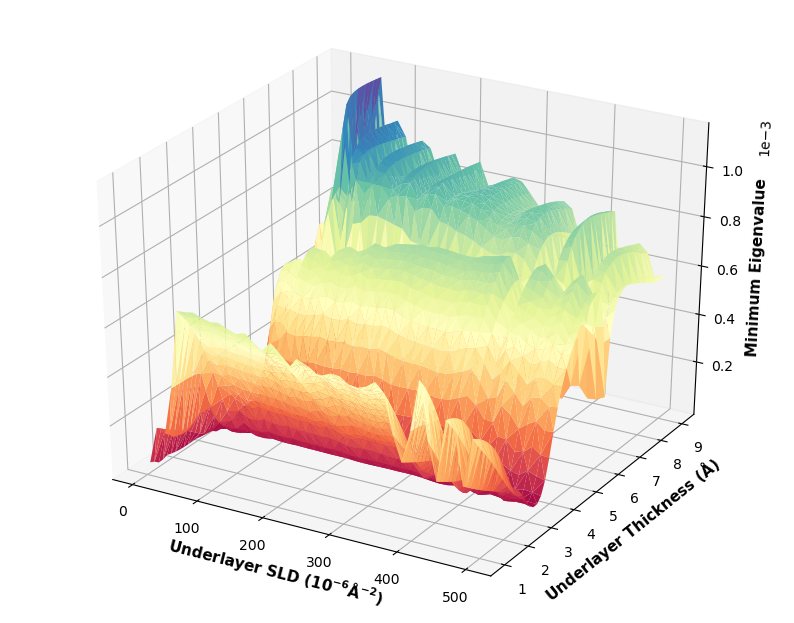

In [4]:
thick, sld = underlayer_choice(bilayer, thickness_range, sld_range, contrasts, angle_times, save_path)
print('Underlayer thickness: {}'.format(round(thick)))
print('Underlayer SLD: {}'.format(round(sld, 1)))